In [25]:
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def renumber_yolo_dataset_nested_splits(
    dataset_root: str,
    output_root: str,
    target_classes: list,
    splits: list = ['train', 'valid', 'test'],
    image_ext: str = '.jpg'
):
    """
    Filters and renumbers YOLO dataset with structure like:
    Dataset/
    ├── data.yaml
    ├── train/
    │   ├── images/
    │   └── labels/
    ├── valid/
    └── test/

    Args:
        dataset_root (str): Path to dataset containing split folders.
        output_root (str): Output root for the filtered dataset.
        target_classes (list): List of class names to keep and remap.
        splits (list): Which splits to process.
        image_ext (str): Image file extension (default .jpg).
    """

    # Load original classes
    data_yaml_path = os.path.join(dataset_root, 'data.yaml')
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
    original_names = data_yaml['names']

    # Map original index → new index
    original_to_new = {}
    for new_id, class_name in enumerate(target_classes):
        if class_name in original_names:
            original_id = original_names.index(class_name)
            original_to_new[original_id] = new_id
        else:
            print(f"Warning: Class '{class_name}' not found in data.yaml")

    print(f"[{os.path.basename(dataset_root)}] Class mapping: {original_to_new}")

    total_kept, total_skipped = 0, 0

    for split in splits:
        split_img_dir = os.path.join(dataset_root, split, 'images')
        split_lbl_dir = os.path.join(dataset_root, split, 'labels')

        if not os.path.exists(split_img_dir) or not os.path.exists(split_lbl_dir):
            print(f"Skipping {split}: missing directories.")
            continue

        out_img_dir = os.path.join(output_root, 'images', split)
        out_lbl_dir = os.path.join(output_root, 'labels', split)
        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_lbl_dir, exist_ok=True)

        for label_file in os.listdir(split_lbl_dir):
            if not label_file.endswith('.txt'):
                continue

            label_path = os.path.join(split_lbl_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                if class_id in original_to_new:
                    parts[0] = str(original_to_new[class_id])
                    new_lines.append(' '.join(parts) + '\n')

            if new_lines:
                total_kept += 1
                out_lbl_path = os.path.join(out_lbl_dir, label_file)
                with open(out_lbl_path, 'w') as f:
                    f.writelines(new_lines)

                img_file = label_file.replace('.txt', image_ext)
                src_img_path = os.path.join(split_img_dir, img_file)
                dst_img_path = os.path.join(out_img_dir, img_file)

                if os.path.exists(src_img_path):
                    shutil.copyfile(src_img_path, dst_img_path)
                else:
                    print(f"Warning: Image not found for {label_file}")
            else:
                total_skipped += 1

    print(f"[{os.path.basename(dataset_root)}] Done: {total_kept} images kept, {total_skipped} skipped.")


In [10]:
target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Fresa", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]
dataset_root = r'..\dataset\YOLO - Raw datasets\Dataset 1'
output_root = r'..\dataset\YOLO - Clean dataset'
renumber_yolo_dataset_nested_splits(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Dataset 1] Class mapping: {37: 0, 27: 1, 30: 2, 20: 3, 7: 4, 23: 7, 5: 8, 22: 10, 12: 11, 24: 12, 8: 13, 6: 14, 31: 16, 1: 20, 19: 23, 0: 24, 9: 25, 17: 26, 2: 27}
[Dataset 1] Done: 7526 images kept, 115 skipped.


In [11]:
for i, target in enumerate(target_classes):
    print(f'{i}:{target}')

0:Tomate
1:Cebolla
2:Patata
3:Lechuga/Endivia
4:Zanahoria
5:Calabacines
6:Pepino
7:Champiñones
8:Brocoli
9:Coliflor
10:Leche
11:Huevos
12:Yogur
13:Queso
14:Mantequilla
15:Merluza
16:Gambas/Langostinos
17:Mix de marisco/molusco
18:Lubina
19:Salmón
20:Plátano
21:Fresa
22:Sandía
23:Limón
24:Manzana
25:Carne pollo
26:Carne cerdo
27:Carne vacuno
28:Salchichas
29:Carne pavo


In [26]:
from collections import defaultdict

def count_classes_in_images(label_dir, class_names=None):
    """
    Count how many images each class appears in (based on YOLO label files).
    Ensures all class names (or indices) are reported, even if count is 0.

    Args:
        label_dir (str): Path to directory with YOLO .txt label files.
        class_names (list): Optional list of class names (indexed by ID)

    Returns:
        dict: class_id -> image_count
    """
    class_image_counts = defaultdict(int)

    for file in os.listdir(label_dir):
        if not file.endswith('.txt'):
            continue

        with open(os.path.join(label_dir, file), 'r') as f:
            lines = f.readlines()

        # Get unique class IDs in this label file
        classes_in_image = set(int(line.split()[0]) for line in lines)
        for class_id in classes_in_image:
            class_image_counts[class_id] += 1

    # Ensure all class IDs are accounted for, even with 0
    total_classes = len(class_names) if class_names else max(class_image_counts.keys(), default=-1) + 1

    print(f"\nClass distribution in '{label_dir}':\n")
    for class_id in range(total_classes):
        count = class_image_counts.get(class_id, 0)
        class_name = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
        print(f"{class_name:30} → {count} image(s)")

    return dict(class_image_counts)


target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Fresa", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]

count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels\train', class_names=target_classes)




Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels\train':

Tomate                         → 4021 image(s)
Cebolla                        → 2735 image(s)
Patata                         → 3704 image(s)
Lechuga/Endivia                → 74 image(s)
Zanahoria                      → 2625 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 2749 image(s)
Brocoli                        → 79 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2453 image(s)
Huevos                         → 2215 image(s)
Yogur                          → 109 image(s)
Queso                          → 3869 image(s)
Mantequilla                    → 2741 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3110 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s

{10: 2453,
 14: 2741,
 23: 103,
 11: 2215,
 3: 74,
 7: 2749,
 2: 3704,
 4: 2625,
 12: 109,
 26: 1271,
 0: 4021,
 24: 1869,
 13: 3869,
 25: 3691,
 1: 2735,
 8: 79,
 27: 1749,
 20: 2903,
 16: 3110}


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels\train':

Tomate                         → 4021 image(s)
Cebolla                        → 2735 image(s)
Patata                         → 3704 image(s)
Lechuga/Endivia                → 74 image(s)
Zanahoria                      → 2625 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 2749 image(s)
Brocoli                        → 79 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2453 image(s)
Huevos                         → 2215 image(s)
Yogur                          → 109 image(s)
Queso                          → 3869 image(s)
Mantequilla                    → 2741 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3110 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s

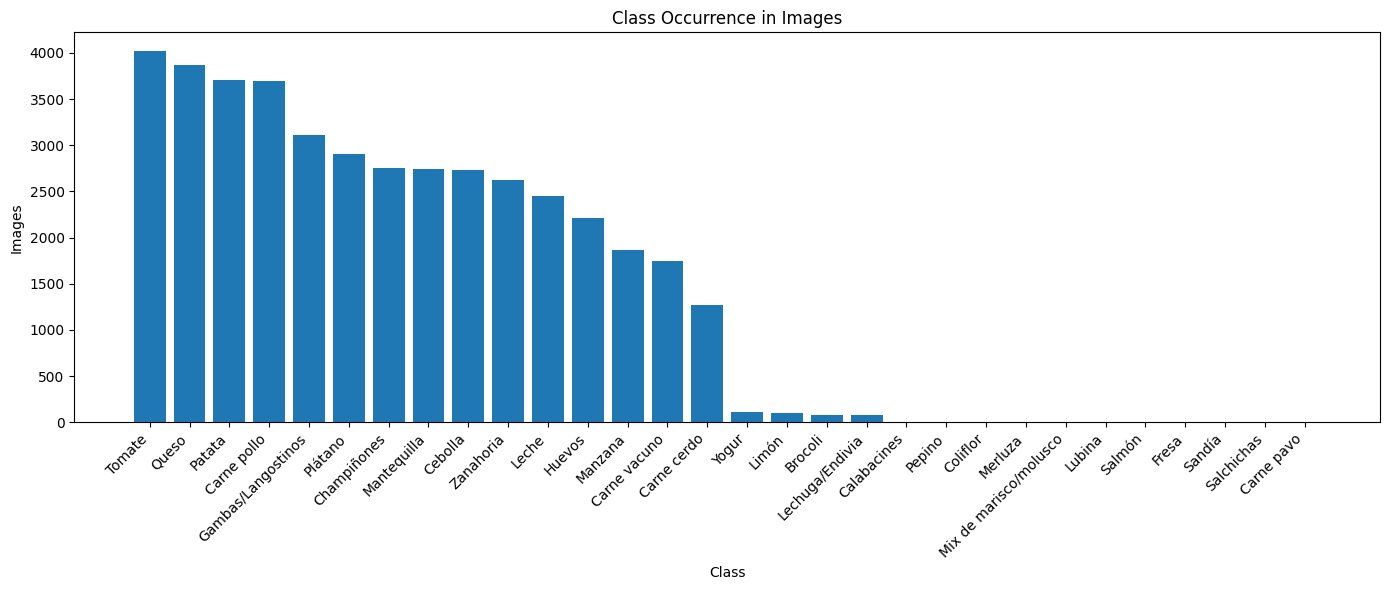

In [ ]:
def plot_class_image_distribution(class_counts, class_names=None, title='Class Occurrence in Images'):
    """
    Plots a bar chart of how many images each class appears in.

    Args:
        class_counts (dict): Dictionary of class_id → image count.
        class_names (list): Optional list of class names.
        title (str): Title for the chart.
    """
    # Sort by frequency
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    class_ids = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    if class_names:
        labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_ids]
    else:
        labels = [f"Class {i}" for i in class_ids]

    plt.figure(figsize=(14, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Images')
    plt.title(title)
    plt.tight_layout()
    plt.show()


counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels\train', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)
